# Sliding Window-based Object Detection

### 0. Package Installation

In [1]:
!pip install numpy
!pip install opencv-python
!pip install matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import random
import math
import csv
import json
from tqdm import tqdm
import pickle
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

print("numpy version : ",np.__version__)
print("opencv version : ",cv2.__version__)

numpy version :  1.20.3
opencv version :  4.5.5


### 1. Implement your own object detection algorithm using HOG and SVM
#### a. Use HOG feature. [2] (you can use OpenCV HOGDescriptor)

In [3]:
# 1. obtain training data
# 2. define features
# 3. define classifier

# hyperparameters
folder = './export/'
test_data_idx = 999
vehicle = ['car', 'truck']
feature_size = 64
step_size=8
NMS_threshold = 0.7
model_name_1 = "./saved_model.sav"
model_name_2 = "./saved_cascade_model.sav"
model_name_3 = "./saved_enhanced_model.sav"

In [4]:
def split_data(folder, test_data_idx=999):
    # split data : train, test (filename, is_vehicle, xmin, ymin, xmax, ymax)
    train_data = []
    test_data = []
    with open(folder + '_annotations.coco.json', 'r') as data_file:
        json_data = json.load(data_file)
    cat_data = json_data["categories"]
    ann_data = json_data["annotations"]
    img_data = json_data["images"]
    for data in ann_data:
        img_id = data["image_id"]
        category_id = data["category_id"]
        bbox = list(map(int, data["bbox"]))
        filename = img_data[img_id]["file_name"]
        is_vehicle = int(cat_data[category_id]["name"] in vehicle)
        if (img_id > test_data_idx):
            train_data.append([filename, is_vehicle, bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
        else :
            test_data.append([filename, is_vehicle, bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
    return train_data, test_data

train_data, test_data = split_data(folder, test_data_idx)
print(len(train_data), len(test_data))

188202 6337


In [5]:
def hog_label_from_data(folder, data_list):
    # extract hog and label from data with normalization
    # positive sample : is_vehicle = 1, flip image
    # negative sample : random sampling 3 samples per image
    HOG = []
    label = []
    descriptor = cv2.HOGDescriptor((feature_size,feature_size), (16,16), (8,8), (8,8), 9)
    random.seed(1)
    for data in tqdm(data_list):
        filename, is_vehicle, xmin, ymin, xmax, ymax = data
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_COLOR)
        if ((xmax-xmin) > feature_size and (ymax-ymin) > feature_size):
            img = cv2.resize(img[ymin:ymax, xmin:xmax], dsize=(feature_size, feature_size), interpolation=cv2.INTER_LINEAR)
            img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            hog1 = descriptor.compute(img)
            HOG.append(hog1)
            label.append(is_vehicle)
            hog2 = descriptor.compute(cv2.flip(img, 1))
            HOG.append(hog2)
            label.append(is_vehicle)
        else :
            for i in range(3):
                y_, x_, _ = img.shape
                y = int(random.random() * (y_-feature_size))
                x = int(random.random() * (x_-feature_size))
                img = img[y:y+feature_size, x:x+feature_size]
                img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                hog = descriptor.compute(img)
                HOG.append(hog)
                label.append(0)
    print("HOG len:", len(HOG))
    print("vehicle data len:", label.count(1))
    return HOG, label

hog, label = hog_label_from_data(folder, train_data)

100%|█████████████████████████████████████████████████████████████████████████| 188202/188202 [20:34<00:00, 152.50it/s]

HOG len: 543762
vehicle data len: 40892


#### b. Train a linear SVM using the training dataset (positive and negative samples) of the vehicle dataset. (you can refer OCR of Hand-written Data using SVM)

In [6]:
def SVM(hog, label):
    model = LinearSVC(penalty='l2', C=0.01, max_iter=1e4)
    model.fit(hog, label)
    return model

print(len(label), len(hog))
print("number of positive sample:", label.count(1))

model = SVM(hog, label)

predicted = model.predict(hog)
print("train accuracy:", accuracy_score(label, predicted))

543762 543762
number of positive sample: 40892
train accuracy: 0.9811038652940073


In [7]:
# save model
pickle.dump(model, open(model_name_1, 'wb'))

In [8]:
# load model
model = pickle.load(open(model_name_1, 'rb'))

#### c. Implement the overall sliding window-based detection pipeline using the classifier you have trained. You can start with the single-scale detector and then extend it to a full multi-scale detector by resizing the input image. You may need to apply the non-maximum suppression step to remove duplicated detections for the final output.

In [9]:
def threshold_rects(probas, rects, threshold):
    # select rects that proba > threshold
    result_rects = []
    for i, proba in enumerate(probas):
        if (proba > threshold):
            result_rects.append(rects[i])
    return result_rects

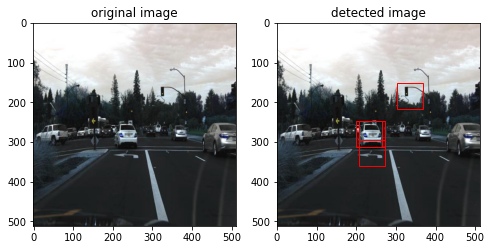

In [10]:
def sliding_window_detection(image, model, window_size=64):
    # return every winodw's proba and position(xmin, ymin, window_size)
    rects = []
    probas = []
    descriptor = cv2.HOGDescriptor((feature_size, feature_size), (16,16), (8,8), (8,8), 9)
    y_, x_, _ = image.shape
    for y in range(0, y_-window_size, step_size):
        for x in range(0, x_-window_size, step_size):
            window = image[y:y+window_size, x:x+window_size]
            window = cv2.normalize(window, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
            window = cv2.resize(window, dsize=(feature_size, feature_size), interpolation=cv2.INTER_LINEAR)
            hog = descriptor.compute(window)
            hog = np.reshape(hog, (1, -1))
            if (type(model).__name__ == 'AdaBoostClassifier'):
                proba = model.predict_proba(hog)[0]
                probas.append(proba[1])
            elif (type(model).__name__ == 'SVC'):
                proba = model.predict_proba(hog)[0]
                probas.append(proba[1])
            else :
                A = model.coef_[0]
                B = model.intercept_
                proba = 1 / (1 + np.exp(-np.dot(A, hog[0]) - B))
                probas.append(proba)
            rects.append([x, y, window_size])
    return probas, rects

example = cv2.imread('./export/1478900482929938289_jpg.rf.AUueBI62ukuiYA6LIMdg.jpg', cv2.IMREAD_COLOR)
probas, raw_rects = sliding_window_detection(example, model, window_size=64)
rects = threshold_rects(probas, raw_rects, threshold=0.6)

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(example)
ax1.set_title("original image")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(example)
ax2.set_title("detected image")
ax2 = plt.gca()
for coord in rects:
    rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)

plt.show()

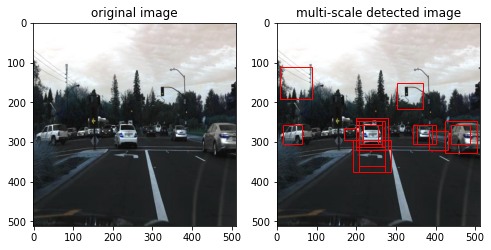

In [11]:
def multi_scale_detector(image, model, min_size=32, max_size=128, step_size=16):
    # return every winodw's proba and position(xmin, ymin, window_size) using sliding_window_detection function
    total_rects = []
    total_probas = []
    for window_size in range(min_size, max_size, step_size):
        probas, rects = sliding_window_detection(image, model, window_size=window_size)
        total_probas.extend(probas)
        total_rects.extend(rects)
    return total_probas, total_rects

probas, raw_rects = multi_scale_detector(example, model, min_size=32, max_size=128, step_size=16)
rects = threshold_rects(probas, raw_rects, threshold=0.6)

fig = plt.figure(figsize=(8,8))

ax1 = fig.add_subplot(1,2,1)
ax1.imshow(example)
ax1.set_title("original image")

ax2 = fig.add_subplot(1,2,2)
ax2.imshow(example)
ax2.set_title("multi-scale detected image")
ax2 = plt.gca()
for coord in rects:
    rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)
    
plt.show()

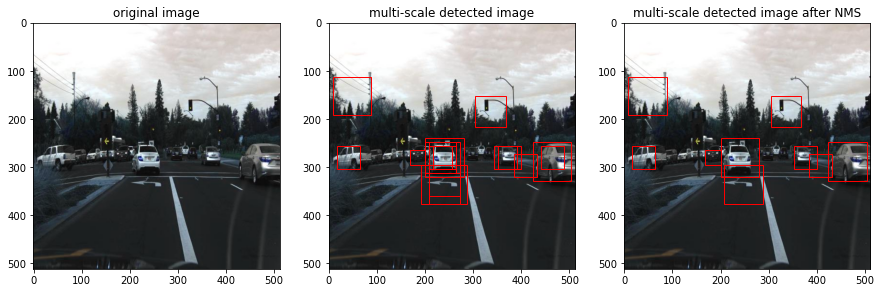

In [12]:
def NMS(rects, threshold=0.5):
    if (len(rects) == 0) : return []
    rects = np.array(rects)
    rects = rects.astype("float")
    pick = []
    x1 = rects[:,0]
    y1 = rects[:,1]
    x2 = rects[:,0] + rects[:,2]
    y2 = rects[:,1] + rects[:,2]
    area = rects[:,2] * rects[:,2]
    idxs = np.argsort(area)
    while (len(idxs) > 0):
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        overlap = (w * h) / area[idxs[:last]]
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > threshold)[0])))
    return rects[pick].astype("int")

probas, raw_rects = multi_scale_detector(example, model, min_size=32, max_size=128, step_size=16)
rects = threshold_rects(probas, raw_rects, threshold=0.6)
rects_NMS = NMS(rects, NMS_threshold)

fig = plt.figure(figsize=(15,15))

ax1 = fig.add_subplot(1,3,1)
ax1.imshow(example)
ax1.set_title("original image")

ax2 = fig.add_subplot(1,3,2)
ax2.imshow(example)
ax2.set_title("multi-scale detected image")
ax2 = plt.gca()
for coord in rects:
    rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
    ax2.add_patch(rect)

ax3 = fig.add_subplot(1,3,3)
ax3.imshow(example)
ax3.set_title("multi-scale detected image after NMS")
ax3 = plt.gca()
for coord in rects_NMS:
    rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
    ax3.add_patch(rect)

plt.show()

#### d. Test your detector on the test dataset of the vehicle dataset.

In [13]:
test_hog, test_label = hog_label_from_data(folder, test_data)

100%|█████████████████████████████████████████████████████████████████████████████| 6337/6337 [00:44<00:00, 143.06it/s]

HOG len: 18338
vehicle data len: 1318


In [14]:
def print_test_accuracy(test_hog, test_label, model):
    predicted = model.predict(test_hog)
    accuracy = accuracy_score(test_label, predicted)
    print("test accuracy:", accuracy)
    return

# SVM accuracy for test data
print_test_accuracy(test_hog, test_label, model)

test accuracy: 0.9828770858326972


#### e. Evaluate the performance using ROC curve, precision-recall curve, and average precision.

In [15]:
def IoU(boxA, boxB):
    # return IoU of boxA and boxB
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def image_and_label(test_data):
    # return image, label
    # label is list of (xmin, ymin, xmax, ymax)
    result = []
    pre_filename = test_data[0][0]
    label = []
    for data in test_data:
        filename, is_vehicle, xmin, ymin, xmax, ymax = data
        if not(is_vehicle == None):
            if not (pre_filename == filename):
                img = cv2.imread(os.path.join(folder, pre_filename), cv2.IMREAD_COLOR)
                result.append([img, label])
                pre_filename = filename
                label = []
            if (is_vehicle):
                label.append([xmin, ymin, xmax, ymax])
    img = cv2.imread(os.path.join(folder, pre_filename), cv2.IMREAD_COLOR)
    result.append([img, label])
    return result

In [16]:
def inference(dataset, model, iou_threshold=0.5):
    # basic iou_threshold is 0.5 but in this model, iou_threshold is 0.6
    # return TP, FP, TN, FN with different threshold(using threshold_rects function)
    threshold = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    TP = np.zeros(len(threshold))
    FP = np.zeros(len(threshold))
    TN = np.zeros(len(threshold))
    FN = np.zeros(len(threshold))
    total = 18886
    for data in tqdm(dataset):
        image, labels = data
        probas, raw_rects = multi_scale_detector(image, model, min_size=32, max_size=160, step_size=16)
        for i, th in enumerate(threshold):
            rects_ = threshold_rects(probas, raw_rects, threshold=th)
            rects = NMS(rects_, NMS_threshold)
            tp = 0
            fp = 0
            for rect in rects:
                boxA = [rect[0], rect[1], rect[0] + rect[2], rect[1] + rect[2]]
                iou = [IoU(boxA, label) > iou_threshold for label in labels]
                if (iou.count(1) > 0) :
                    tp = tp + 1
                else:
                    fp = fp + 1
            tp = min(tp, len(labels))
            fp = len(rects) - tp
            TP[i] = TP[i] + tp
            FP[i] = FP[i] + fp
            FN[i] = FN[i] + len(labels) - tp
            TN[i] = TN[i] + total - len(labels) - fp
    return TP, FP, TN, FN

In [17]:
def plot_roc_curve(TP, FP, TN, FN):
    # plot roc curve
    TPR = TP / (TP + FN)
    FPR = FP / (FP + TN)
    TPR = np.where(np.isnan(TPR), 0, TPR).tolist()
    FPR = np.where(np.isnan(FPR), 0, FPR).tolist()
    idx = sorted(range(len(FPR)), key=lambda k: FPR[k])
    FPR = sorted(FPR)
    TPR = [TPR[i] for i in idx]
    print("TPR:", TPR)
    print("FPR:", FPR)
    plt.plot(FPR, TPR, color='red', label='ROC')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend()
    plt.show()
    return

def plot_precision_recall_curve(TP, FP, TN, FN):
    # plot precision recall curve
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    Precision = np.where(np.isnan(Precision), 0, Precision).tolist()
    Recall = np.where(np.isnan(Recall), 0, Recall).tolist()
    print("Precision:", Precision)
    print("Recall:", Recall)
    plt.plot(Recall, Precision, color='red', label='Precision-Recall Curve')
    plt.xlabel('recall')
    plt.ylabel('precision')
    plt.legend()
    plt.show()
    return

def precision_average(TP, FP, TN, FN):
    # calculate precision average
    Precision = TP / (TP + FP)
    Recall = TP / (TP + FN)
    Precision = np.where(np.isnan(Precision), 0, Precision).tolist()
    Recall = np.where(np.isnan(Recall), 0, Recall).tolist()
    minimum = min(Recall)
    maximum = max(Recall)
    delta = (maximum - minimum)/len(Recall)
    Precision_Average = 0
    for i in range(len(Recall)):
        Precision_Average = Precision_Average + Precision[i] * delta
    return Precision_Average

In [18]:
for_inference = image_and_label(test_data)
TP, FP, TN, FN = inference(for_inference, model, iou_threshold=0.6)

100%|██████████████████████████████████████████████████████████████████████████████| 868/868 [1:00:45<00:00,  4.20s/it]


TPR: [0.00555185431934266, 0.046413502109704644, 0.09571396846546747, 0.11103708638685321, 0.07395069953364423, 0.04930046635576282, 0.04019542527204086, 0.03375527426160337, 0.03286697757050855]
FPR: [2.440729180046185e-07, 5.857750032110844e-06, 5.247567737099297e-05, 0.0002453543008241427, 0.0007461919285696198, 0.001608501547879937, 0.0025378091831825215, 0.0034039629509514113, 0.004068878597825494]


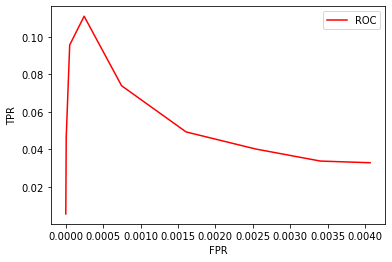

Precision: [0.002214541156050336, 0.0027172941470914227, 0.004333046059561429, 0.008351201895948538, 0.026508517751950327, 0.11059500110595001, 0.3338497288923315, 0.6852459016393443, 0.8620689655172413]
Recall: [0.03286697757050855, 0.03375527426160337, 0.04019542527204086, 0.04930046635576282, 0.07395069953364423, 0.11103708638685321, 0.09571396846546747, 0.046413502109704644, 0.00555185431934266]


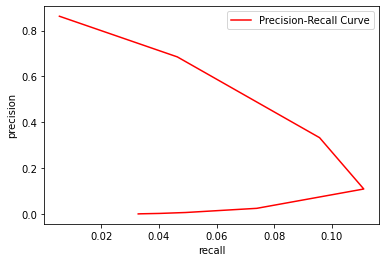

Precision Average: 0.023861746345118017


In [19]:
plot_roc_curve(TP, FP, TN, FN)
plot_precision_recall_curve(TP, FP, TN, FN)
print("Precision Average:", precision_average(TP, FP, TN, FN))

#### f. Visualize the detection results (detected bounding boxes) in the image.

In [20]:
def visualize_result(dataset, model, iou_threshold=0.5):
    for data in dataset:
        image, labels = data
        probas, raw_rects = multi_scale_detector(image, model, 32, 160, 16)
        rects_ = threshold_rects(probas, raw_rects, threshold=iou_threshold)
        rects = NMS(rects_, NMS_threshold)
        fig = plt.figure(figsize=(15,15))
        
        ax1 = fig.add_subplot(1,3,1)
        ax1.imshow(image)
        ax1.set_title("raw detected image")
        ax1 = plt.gca()
        for coord in rects_:
            rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
            ax1.add_patch(rect)

        ax2 = fig.add_subplot(1,3,2)
        ax2.imshow(image)
        ax2.set_title("NMS detected image")
        ax2 = plt.gca()
        for coord in rects:
            rect = patches.Rectangle((coord[0], coord[1]), coord[2], coord[2], linewidth=1, edgecolor='r', facecolor='none')
            ax2.add_patch(rect)

        ax3 = fig.add_subplot(1,3,3)
        ax3.imshow(image)
        ax3.set_title("label image")
        ax3 = plt.gca()
        for label in labels:
            rect = patches.Rectangle((label[0], label[1]), label[2] - label[0], label[3] - label[1], linewidth=1, edgecolor='r', facecolor='none')
            ax3.add_patch(rect)

        plt.show()
    return

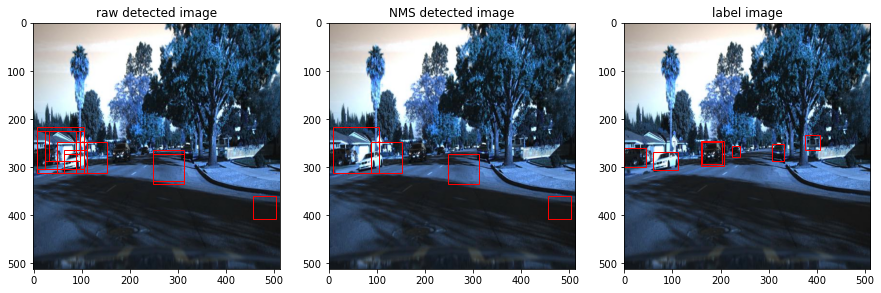

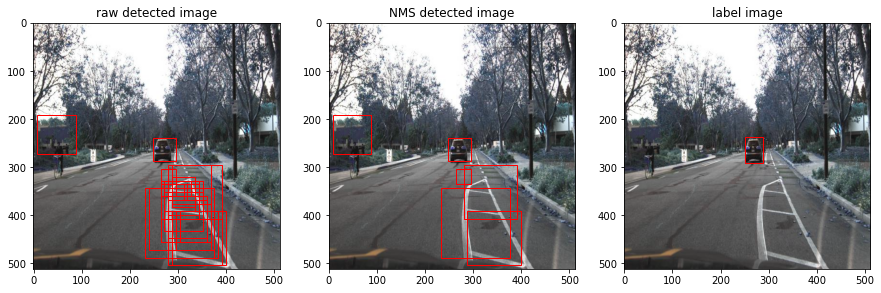

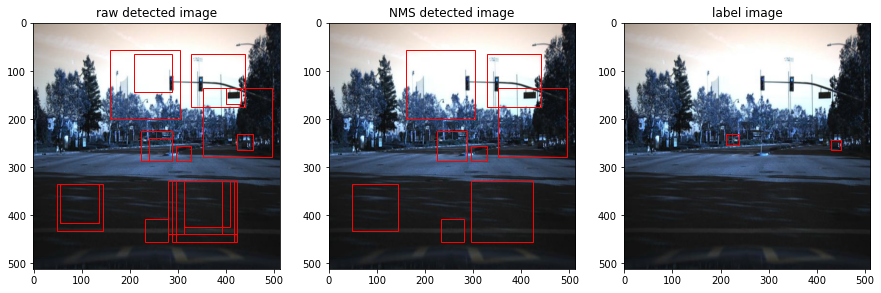

In [21]:
index = np.random.choice(len(for_inference), 3)
random_test_data = [for_inference[i] for i in index]
visualize_result(random_test_data, model, iou_threshold=0.6)

### 2. Make your algorithm fast with a cascade architecture.
#### a. Implement the cascade of HOG algorithm as described in [2] "Histograms of Oriented Gradients for Human Detection"

In [22]:
def cascade_classifier(hog, label):
    model = AdaBoostClassifier(n_estimators=5, random_state=0)
    model.fit(hog, label)
    return model

cascade_model = cascade_classifier(hog, label)

predicted = cascade_model.predict(hog)
print("train accuracy:", accuracy_score(label, predicted))

train accuracy: 0.9453161493447501


In [23]:
# save model
pickle.dump(cascade_model, open(model_name_2, 'wb'))

In [24]:
# load model
cascade_model = pickle.load(open(model_name_2, 'rb'))

#### b. Test your new algorithm on the test dataset and evaluate the performance as in 1-e.

In [25]:
# Cascade accuracy for test data
print_test_accuracy(test_hog, test_label, cascade_model)

test accuracy: 0.9512487730395899


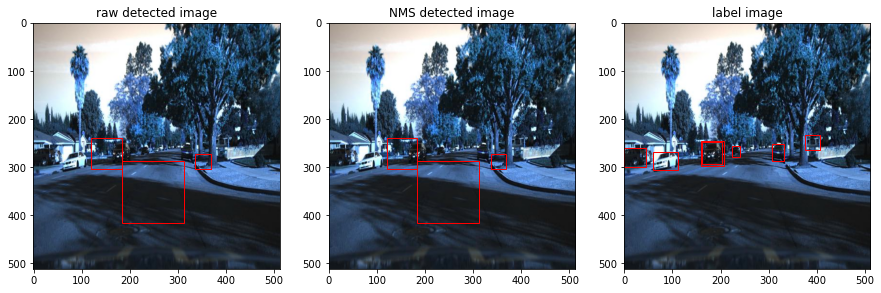

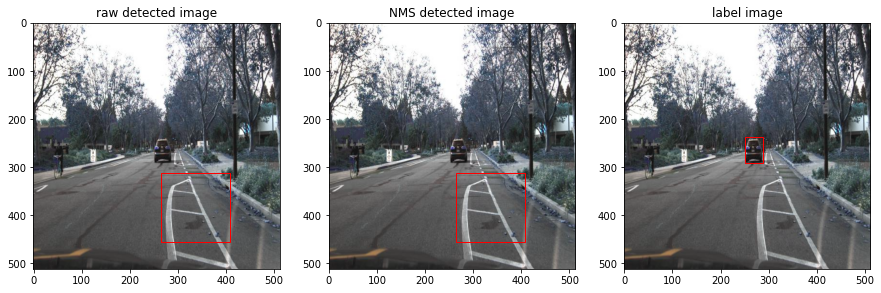

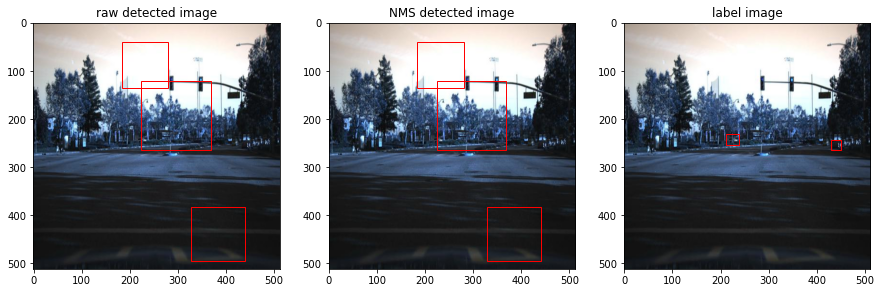

In [26]:
visualize_result(random_test_data, cascade_model, iou_threshold=0.6)

100%|██████████████████████████████████████████████████████████████████████████████| 868/868 [5:19:46<00:00, 22.10s/it]

TPR: [0.0, 0.0, 0.0, 0.060626249167221855, 0.05374194981123695, 0.03397734843437708, 0.03419942260715079, 0.03242282922496114, 0.03242282922496114]
FPR: [0.0, 0.0, 0.0, 0.0002136248214835423, 0.001423433257802935, 0.0027097585539167753, 0.0038490909351623346, 0.0043870886646740145, 0.0043870886646740145]


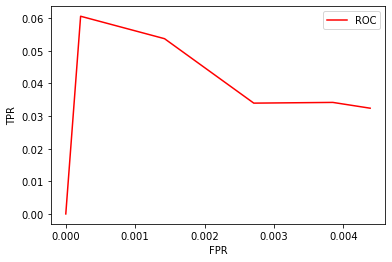

C:\Users\Jeongmin\AppData\Local\Temp/ipykernel_1764/2825509596.py:21: RuntimeWarning: invalid value encountered in true_divide
  Precision = TP / (TP + FP)


Precision: [0.0020265393370717893, 0.0020265393370717893, 0.002435360164465881, 0.0034334186077824157, 0.010267288926601613, 0.07233704292527822, 0.0, 0.0, 0.0]
Recall: [0.03242282922496114, 0.03242282922496114, 0.03419942260715079, 0.03397734843437708, 0.05374194981123695, 0.060626249167221855, 0.0, 0.0, 0.0]


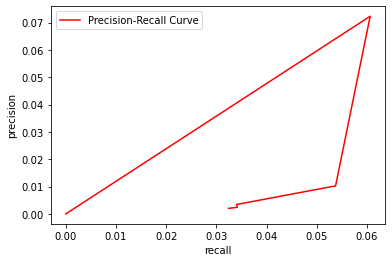

Precision Average: 0.0006232795340989507


C:\Users\Jeongmin\AppData\Local\Temp/ipykernel_1764/2825509596.py:36: RuntimeWarning: invalid value encountered in true_divide
  Precision = TP / (TP + FP)


In [27]:
for_inference = image_and_label(test_data)
TP, FP, TN, FN = inference(for_inference, cascade_model, iou_threshold=0.6)

plot_roc_curve(TP, FP, TN, FN)
plot_precision_recall_curve(TP, FP, TN, FN)
print("Precision Average:", precision_average(TP, FP, TN, FN))

#### c. Compare and discuss the results with the previous ones in terms of accuracy and speed.

In [28]:
# train accuracy :     SVM = 0.98     Cascade = 0.94
# test accuracy :      SVM = 0.98     Cascade = 0.95
# train speed :        SVM = 20mins   Cascade = 30mins
# inference speed :    SVM = 60mins   Cascade = 330mins
# TPR(th = 0.6) :      SVM = 0.75     Cascade = 0.02
# FPR(th = 0.6) :      SVM = 0.03     Cascade = 0.0016
# Precision(th = 0.6)  SVM = 0.10     Cascade = 0.07
# Recall(th = 0.6)     SVM = 0.48     Cascade = 0.05
# Average Precision    SVM = 0.191    Cascade = 0.013

# length of train data(hog) is about 540,000 so that deep cascade model can't used
# if I train deep cascade model, it would be better than SVM model
# but in this assignment, SVM has better performance in all aspects accuracy and speed

### 3. How can you further improve the performance of your algorithm in terms of either accuracy or speed? Propose your own idea and show it.

In [29]:
def split_data_enhanced(folder, test_data_idx=999):
    # split data : train, test (filename, is_vehicle, xmin, ymin, xmax, ymax)
    train_data = []
    test_data = []
    with open(folder + '_annotations.coco.json', 'r') as data_file:
        json_data = json.load(data_file)
    cat_data = json_data["categories"]
    ann_data = json_data["annotations"]
    img_data = json_data["images"]
    idx = 0
    for data in ann_data:
        img_id = data["image_id"]
        category_id = data["category_id"]
        bbox = list(map(int, data["bbox"]))
        filename = img_data[img_id]["file_name"]
        is_vehicle = int(cat_data[category_id]["name"] in vehicle)
        if (idx == img_id):
            if (img_id > test_data_idx):
                train_data.append([filename, is_vehicle, bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
            else :
                test_data.append([filename, is_vehicle, bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]])
        else :
            while (idx < img_id):
                filename = img_data[idx]["file_name"]
                if (img_id > test_data_idx):
                    train_data.append([filename, None, None, None, None, None])
                idx = idx + 1
    return train_data, test_data

def hog_label_from_data_enhanced(folder, data_list):
    HOG = []
    label = []
    descriptor = cv2.HOGDescriptor((feature_size,feature_size), (16,16), (8,8), (8,8), 9)
    random.seed(1)
    for data in tqdm(data_list):
        image, rects = data
        if (len(rects) == 0):
            for i in range(500):
                y_, x_, _ = image.shape
                y = int(random.random() * (y_-feature_size))
                x = int(random.random() * (x_-feature_size))
                img = image[y:y+feature_size, x:x+feature_size]
                img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                hog = descriptor.compute(img)
                HOG.append(hog)
                label.append(0)
        else :
            for rect in rects:
                xmin, ymin, xmax, ymax = rect
                if ((xmax-xmin) > feature_size and (ymax-ymin) > feature_size):
                    img = cv2.resize(image[ymin:ymax, xmin:xmax], dsize=(feature_size, feature_size), interpolation=cv2.INTER_LINEAR)
                    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
                    hog1 = descriptor.compute(img)
                    HOG.append(hog1)
                    label.append(1)
                    hog2 = descriptor.compute(cv2.flip(img, 1))
                    HOG.append(hog2)
                    label.append(1)
    print("HOG len:", len(HOG))
    print("vehicle data len:", label.count(1))
    return HOG, label

In [30]:
# split data and extract hog from data
train_data_enhanced, test_data_enhanced = split_data_enhanced(folder, test_data_idx=999)
train_data_ = image_and_label(train_data_enhanced[0:10000])
hog, label = hog_label_from_data_enhanced(folder, train_data_)

100%|█████████████████████████████████████████████████████████████████████████████| 1190/1190 [00:02<00:00, 551.14it/s]


HOG len: 14510
vehicle data len: 1510


In [31]:
# train enhanced_model
print(len(label), len(hog))
print("number of positive sample:", label.count(1))

enhanced_model = SVM(hog, label)

predicted = enhanced_model.predict(hog)
print("train accuracy:", accuracy_score(label, predicted))

14510 14510
number of positive sample: 1510
train accuracy: 0.9760165403170228


In [32]:
# save model
pickle.dump(enhanced_model, open(model_name_3, 'wb'))

In [33]:
# load model
enhanced_model = pickle.load(open(model_name_3, 'rb'))

In [34]:
# Enhanced accuracy for test data
print_test_accuracy(test_hog, test_label, enhanced_model)

test accuracy: 0.975624386519795


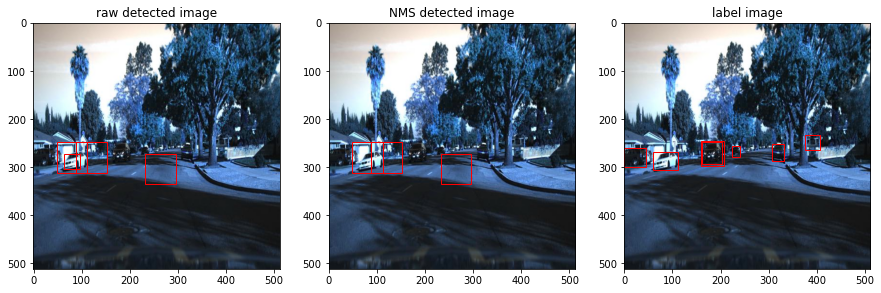

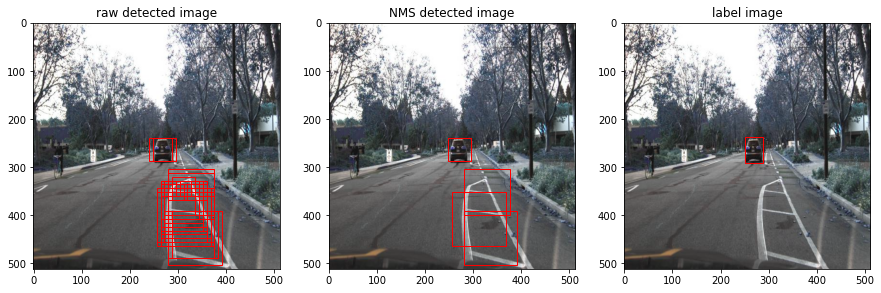

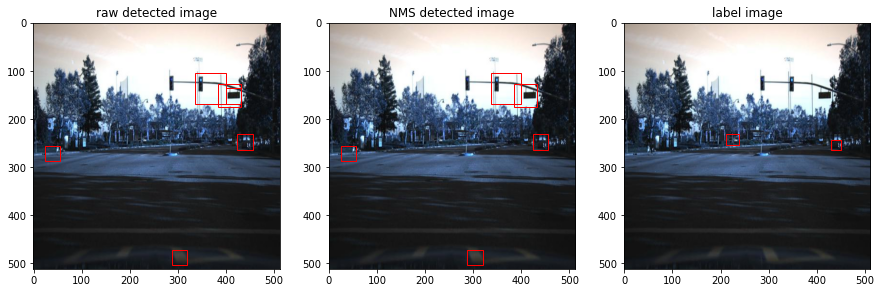

In [35]:
visualize_result(random_test_data, enhanced_model, iou_threshold=0.6)

100%|████████████████████████████████████████████████████████████████████████████████| 868/868 [58:51<00:00,  4.07s/it]

TPR: [0.00022207417277370642, 0.028869642460581834, 0.09016211414612481, 0.12880302020874973, 0.09971130357539418, 0.047968021319120584, 0.03664223850766156, 0.030202087497224073, 0.026426826560071063]
FPR: [0.0, 1.952583344036948e-06, 2.7702276193524198e-05, 0.0002117332563690065, 0.0008561467781307004, 0.0019840077322300425, 0.002969635193362193, 0.003957154219608879, 0.00428750691412813]


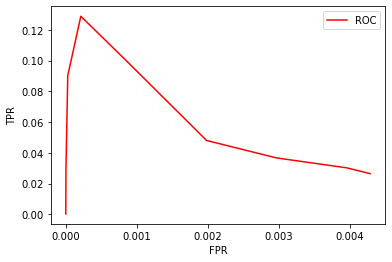

Precision: [0.0016907011437095971, 0.002092694035821998, 0.0033788626543525893, 0.006599248418930066, 0.03100828729281768, 0.14320987654320988, 0.4720930232558139, 0.8024691358024691, 1.0]
Recall: [0.026426826560071063, 0.030202087497224073, 0.03664223850766156, 0.047968021319120584, 0.09971130357539418, 0.12880302020874973, 0.09016211414612481, 0.028869642460581834, 0.00022207417277370642]


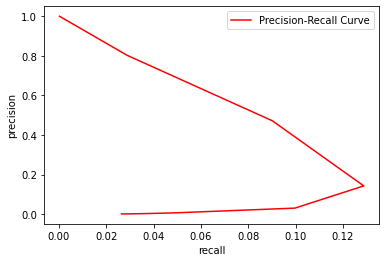

Precision Average: 0.03518177311610002


In [36]:
# performance of enhanced model
for_inference = image_and_label(test_data)
TP, FP, TN, FN = inference(for_inference, enhanced_model, iou_threshold=0.6)

plot_roc_curve(TP, FP, TN, FN)
plot_precision_recall_curve(TP, FP, TN, FN)
print("Precision Average:", precision_average(TP, FP, TN, FN))

In [37]:
# train accuracy :     SVM = 0.98     Cascade = 0.94     Enhanced = 0.98
# test accuracy :      SVM = 0.98     Cascade = 0.95     Enhanced = 0.98
# train speed :        SVM = 20mins   Cascade = 30mins   Enhanced = 1mins
# inference speed :    SVM = 60mins   Cascade = 330mins  Enhanced = 60mins
# TPR(th = 0.6) :      SVM = 0.75,    Cascade = 0.02     Enhanced = 0.80
# FPR(th = 0.6) :      SVM = 0.03     Cascade = 0.0016   Enhanced = 0.04
# Precision(th = 0.6)  SVM = 0.10     Cascade = 0.07     Enhanced = 0.12
# Recall(th = 0.6)     SVM = 0.48     Cascade = 0.05     Enhanced = 0.48
# Average Precision    SVM = 0.191    Cascade = 0.013    Enhanced = 0.223

# new enhanced model has lots of negative samples from image that there is no vehicle
# this model has advantage of train speed and Average Precision